# EDA of the dataset

### Our datasets
main dataset  - ["European Soccer Database" (ESD)](https://www.kaggle.com/hugomathien/soccer//) 

Additional datasets -

- "UK football stadiums" -  [UK stadiums description](https://www.doogal.co.uk/FootballStadiums.php//) 
- Position in league table per stage - from [worldfootball](https://www.worldfootball.net/schedule//)

The "European Soccer Database" consists of three main tables:
- Match - features for each match of 2008-2016 seasons
- Player -  player attributes
- Team - team attributes

The worldfootball dataset was extracted directly from the website. In order to receive the position of each team in each stage of the league we wrote a script named extract_table_from_url(attached together with this file) which goes through pages such as [this](http://www.worldfootball.net/schedule/eng-premier-league-2016-2017-spieltag/9/) and write the data to an csv file. 



### EDA update 

In this notebook we worked on three issues:
1) Engineering new features 
2) Dealing with draw class poor prediction rates
3) Using Different classification models


#### New features:
- points - number of points in current league stage
- norm_points - number of points in current league stage relative to highest number of points in current stage
- position - position in league table
- straight_wins - if last game was won, number of wins in a row
- straight_loses - if last game was lost, number of losses in a row
- straight_draws - - if last game ended with a draw, number of draws in a row 
- pos_goals - goals scored in last X games
- neg_goals - goals received in last X games
- tot_pos_goals - goals scored since the begining of the season
- tot_neg_goals - goals received since the begining of the season
- goals_diff - tot_pos_goals minus tot_neg_goals
- wins - wins in last X games 
- loses - loses in last X games

X is the size of the moving window we used.
In this file we set X to be 5, in the future we will try different size for X.
All of these features were created for both home and away team for each match. 

#### Draw class:
As we saw on our first attempt classifier, the classifier never chose the draw class, to deal with this issue we tried two methods, both based on demanding a certain threshold crossing for a win/ lose decision:
1) relative threshold - the threshold is determined on the percentage win and lose cases takes out of 1.
2) absolute threshold -  win/lose classed needs to cross a predetermined threshold in order for them to be picked

#### Classification models:

In order to get a perspective of the preformance we can achive, we tried using the following models:
- Logistic Regression
- KNN
- SVM
- Decision Tree
- Random Forest
- A combination of all models

After trying all of these models the best f1-score was received using Logistic Regression with the second type of threshold.



#### General Impotrs:

In [612]:
import sqlite3
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Read all DB's:

In [613]:
#Availible Leagues:
#"England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"

current_leagues = ["England_Premier_League"]#["England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"]

#Not Availible Leagues (yet):
#Italy_Serie_A/Switzerland_Super_League

In [614]:
basic_info       = ["league","season","stage","home_team_name","away_team_name","score"]
betting_odds     = ["B365H","WHH","VCH","B365A","WHA","VCA","B365D","WHD","VCD"]
new_features     = ["points","norm_points","position","straight_wins","straight_loses","straight_draws","pos_goals","neg_goals","tot_pos_goals","tot_neg_goals","goals_diff","wins","loses"]
important_info   = basic_info + ["home_team_goal","away_team_goal"]

percent_per_season_columns = ["home_win_season_percent","home_lose_season_percent","away_win_season_percent","away_lose_season_percent"]
percent_total_columns      = ["home_win_percent","home_lose_percent","away_win_percent","away_lose_percent"]

home_away        = ["home","away"]

new_columns      = important_info + betting_odds

new_new_columns = []

for r in itertools.product(home_away,new_features): new_new_columns.append(r[0] +"_"+ r[1])

In [615]:
features_list = new_new_columns + percent_per_season_columns + percent_total_columns + betting_odds # + ["stage"]
labels_list   = "win_lose_draw"

In [616]:
final_matches_db = pd.read_csv("databases/my_matches_db.csv", encoding='latin-1', index_col = [0])

In [617]:
all_leagues = final_matches_db["league"].unique()

for league in all_leagues:
    if league.replace(" ","_") in current_leagues: continue
    final_matches_db = final_matches_db[final_matches_db["league"] != league]

In [618]:
final_matches_db

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.000000,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.50,4.50,5.50,0
1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.000000,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.50,5.50,6.00,1
2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.000000,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.60,3.30,3.80,2
3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.000000,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.40,3.20,3.50,1
4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.000000,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.40,3.20,3.50,1
5,England Premier League,2008/2009,1,Everton,Blackburn Rovers,2 - 3,0.0,0.000000,0.0,0.0,...,2.00,1.95,2.05,4.00,3.50,4.00,3.30,3.10,3.30,2
6,England Premier League,2008/2009,1,Middlesbrough,Tottenham Hotspur,2 - 1,0.0,0.000000,0.0,0.0,...,3.20,2.90,3.20,2.25,2.15,2.30,3.40,3.20,3.40,1
7,England Premier League,2008/2009,1,Bolton Wanderers,Stoke City,3 - 1,0.0,0.000000,0.0,0.0,...,1.83,1.80,1.85,4.50,4.00,4.80,3.50,3.10,3.40,1
8,England Premier League,2008/2009,1,Hull City,Fulham,2 - 1,0.0,0.000000,0.0,0.0,...,2.60,2.50,2.60,2.80,2.62,2.80,3.20,2.90,3.40,1
9,England Premier League,2008/2009,1,Chelsea,Portsmouth,4 - 0,0.0,0.000000,0.0,0.0,...,1.33,1.30,1.33,10.00,8.50,11.00,5.00,4.20,5.00,1


#### Functions:

#### Hyperparameters:

In [619]:
#window_size = 5
threshold_1 = 1.5
threshold_2 = {1:0.45,2:0.35}

#### Data Visualizations:

In [620]:
#sns.pairplot(new_matches[features_list].dropna(axis=0))

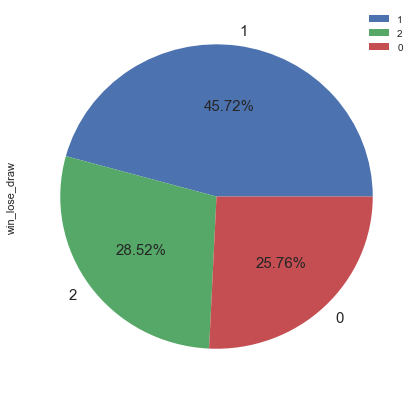

In [621]:
final_matches_db["win_lose_draw"].value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)

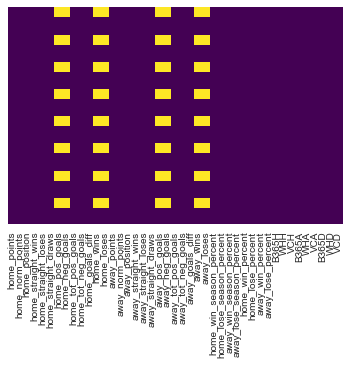

In [622]:
sns.heatmap(final_matches_db[features_list].isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Split the data:

In [623]:
def my_train_test_split(features, labels, test_size):   
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_leagues = features["league"].unique()
    for league in all_leagues:
        min_stage = features[features["league"] == league]["stage"].min()
        max_stage = features[features["league"] == league]["stage"].max()
        
        num_of_stages    = max_stage - min_stage + 1
        test_num_stages  = round(num_of_stages*test_size)
        train_num_stages = num_of_stages-test_num_stages
    
        X_train[league] = features[features["stage"] <= (min_stage + train_num_stages)].drop(["league","stage"],axis=1)
        X_test[league]  = features[features["stage"] >= (max_stage - test_num_stages + 1)].drop(["league","stage"],axis=1)
        y_train[league] = labels[labels["stage"] <= (min_stage + train_num_stages)]["win_lose_draw"]
        y_test[league]  = labels[labels["stage"] >= (max_stage - test_num_stages + 1)]["win_lose_draw"]
        
    return pd.concat(X_train,ignore_index=True),pd.concat(X_test,ignore_index=True),pd.concat(y_train,ignore_index=True),pd.concat(y_test,ignore_index=True)

In [624]:
temp     = final_matches_db.dropna(axis = 0)
features = temp[features_list]
labels   = temp[labels_list]

#temp_feat = temp[["league","stage"] + features_list]
#temp_labe = temp[["league","stage"] + [labels_list]]

In [625]:
print("Num of features =",len(features_list))

Num of features = 43


In [626]:
from sklearn.model_selection import train_test_split

In [627]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.40, random_state=103)

In [628]:
#X_train, X_test, y_train, y_test = my_train_test_split(temp_feat, temp_labe, 0.4)

####  Logistic Regression model

In [629]:
from sklearn.linear_model import LogisticRegression

In [630]:
logmodel = LogisticRegression()

In [631]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [632]:
predictions = logmodel.predict(X_test)

#### Learning Evaluation:

In [633]:
from sklearn.metrics import classification_report,confusion_matrix

In [634]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.31      0.09      0.14       195
          1       0.59      0.76      0.67       373
          2       0.44      0.51      0.47       200

avg / total       0.48      0.53      0.48       768



In [635]:
print(confusion_matrix(y_test,predictions))

[[ 18 114  63]
 [ 23 285  65]
 [ 18  81 101]]


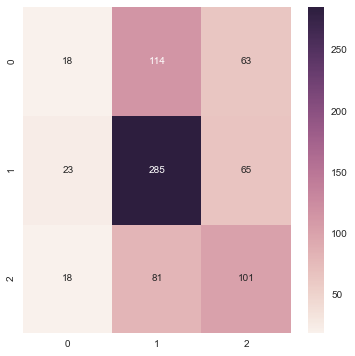

In [636]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True, fmt="d")

In [637]:
coeff_df = pd.DataFrame(logmodel.coef_.T,features.columns,
                        columns=['Coefficient_home','Coefficient_away','Coefficient_draw'])
coeff_df

,Coefficient_home,Coefficient_away,Coefficient_draw
home_points,-0.018685,0.003927,0.013486
home_norm_points,-0.159787,0.111196,-0.069413
home_position,-0.020676,0.003777,0.002124
home_straight_wins,0.028316,-0.077885,0.069563
home_straight_loses,0.105808,-0.137533,0.021720
home_straight_draws,0.065840,-0.123406,0.062535
home_pos_goals,-0.017253,0.022510,-0.006725
home_neg_goals,0.065596,-0.052521,-0.009777
home_tot_pos_goals,-0.020001,0.017329,-0.001221
home_tot_neg_goals,-0.019963,0.010565,0.008310


#### Adding thresold to Logistic Regression model

In [638]:
soft_decision = logmodel.predict_proba(X_test)

In [639]:
def thresh_1(probs,threshold):
    decision  = -1
    if max(probs) == probs[0]: decision = 0
    else:
        home_away_probs = list(probs[[1,2]])
        if max(home_away_probs) > threshold*min(home_away_probs): decision = (home_away_probs.index(max(home_away_probs)) + 1)
    if decision == -1: decision = 0
    return decision

def thresh_2(probs,threshold):
    decision  = -1
    if    probs[1] > threshold[1]: decision = 1
    elif  probs[2] > threshold[2]: decision = 2
    else:                          decision = 0
    return decision

In [640]:
new_predictions = {"threshold_1":[],"threshold_2":[]}

for aa in range(len(soft_decision)):
    new_predictions["threshold_1"].append(thresh_1(soft_decision[aa],threshold_1))
    new_predictions["threshold_2"].append(thresh_2(soft_decision[aa],threshold_2))

In [641]:
for thresh,prediction in new_predictions.items():
    print("threshold =",thresh)
    print(classification_report(y_test,prediction))
    print(confusion_matrix(y_test,prediction),"\n\n")

threshold = threshold_1
             precision    recall  f1-score   support

          0       0.29      0.33      0.31       195
          1       0.64      0.65      0.65       373
          2       0.48      0.40      0.44       200

avg / total       0.51      0.51      0.51       768

[[ 64  88  43]
 [ 86 244  43]
 [ 69  51  80]] 


threshold = threshold_2
             precision    recall  f1-score   support

          0       0.24      0.17      0.20       195
          1       0.63      0.63      0.63       373
          2       0.42      0.55      0.48       200

avg / total       0.48      0.49      0.48       768

[[ 33  85  77]
 [ 66 234  73]
 [ 40  50 110]] 




#### Adding more models:

In [642]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### KNN:

In [643]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

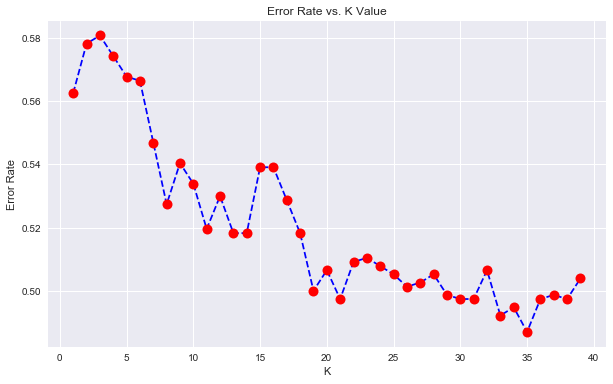

In [644]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [645]:
best_n_neighbors = error_rate.index(min(error_rate))+1
print("best_n_neighbors =",best_n_neighbors)

best_n_neighbors = 35


In [646]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)

#### SVM:

In [647]:
svm = SVC()

In [648]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001]} 
svm_grid   = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

#### Decision Tree:

In [649]:
dtree = DecisionTreeClassifier()

In [650]:
rfc = RandomForestClassifier(n_estimators=600)

#### Train and Predict using all model:

In [651]:
all_models         = [knn,svm,svm_grid,rfc,dtree]
models_predictions = {}

for thresh,prediction in new_predictions.items():
    models_predictions[str(logmodel).split("(")[0] + " " + thresh] = prediction

for model in all_models:
    classifier_name = str(model).split("(")[0]
    model.fit(X_train,y_train)
    models_predictions[classifier_name] = model.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................... C=0.1, gamma=1, score=0.451948, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, score=0.453125, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................... C=0.1, gamma=1, score=0.451697, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................. C=0.1, gamma=0.1, score=0.451948, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................. C=0.1, gamma=0.1, score=0.453125, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................. C=0.1, gamma=0.1, score=0.451697, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................ C=0.1, gamma=0.01, score=0.451948, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................ C=0.1, gamma=0.01, score=0.453125, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[CV] .................. C=1000, gamma=1, score=0.451948, total=   0.0s
[CV] C=1000, gamma=1 .................................................
[CV] .................. C=1000, gamma=1, score=0.453125, total=   0.0s
[CV] C=1000, gamma=1 .................................................
[CV] .................. C=1000, gamma=1, score=0.451697, total=   0.0s
[CV] C=1000, gamma=0.1 ...............................................
[CV] ................ C=1000, gamma=0.1, score=0.451948, total=   0.0s
[CV] C=1000, gamma=0.1 ...............................................
[CV] ................ C=1000, gamma=0.1, score=0.453125, total=   0.0s
[CV] C=1000, gamma=0.1 ...............................................
[CV] ................ C=1000, gamma=0.1, score=0.451697, total=   0.0s
[CV] C=1000, gamma=0.01 ..............................................
[CV] ............... C=1000, gamma=0.01, score=0.438961, total=   0.0s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   11.0s finished


In [652]:
for model_name,model_prediction in models_predictions.items():
    print("classifier =",model_name)
    print(classification_report(y_test,model_prediction))
    print(confusion_matrix(y_test,model_prediction),"\n\n")

classifier = LogisticRegression threshold_2
             precision    recall  f1-score   support

          0       0.24      0.17      0.20       195
          1       0.63      0.63      0.63       373
          2       0.42      0.55      0.48       200

avg / total       0.48      0.49      0.48       768

[[ 33  85  77]
 [ 66 234  73]
 [ 40  50 110]] 


classifier = DecisionTreeClassifier
             precision    recall  f1-score   support

          0       0.26      0.26      0.26       195
          1       0.56      0.53      0.55       373
          2       0.37      0.41      0.39       200

avg / total       0.44      0.43      0.43       768

[[ 50  86  59]
 [ 94 198  81]
 [ 51  67  82]] 


classifier = SVC
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       195
          1       0.49      1.00      0.65       373
          2       1.00      0.01      0.01       200

avg / total       0.50      0.49      0.32       768

[

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Nueral Network model

In [653]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from sklearn import preprocessing

In [681]:
L   = [100,100]
dim = len(features.columns)
k   = 3

nb_epoch   = 15
batch_size = 1500
dropout    = 0.5

X_train_mat = X_train.as_matrix()
X_test_mat  = X_test.as_matrix()
y_train_mat = y_train.as_matrix()
y_test_mat  = y_test.as_matrix()
Y_train_mat = np_utils.to_categorical(y_train, k)
Y_test_mat  = np_utils.to_categorical(y_test, k)

In [682]:
# normalizer = preprocessing.Normalizer().fit(X_train)
# X_train_norm = normalizer.transform(X_train)                            
# X_test_norm = normalizer.transform(X_test)    
X_train_mat.max()

100.0

In [683]:
nn_model = Sequential()
nn_model.add(Dense(L[0], input_dim=dim, init='normal', activation='relu'))
nn_model.add(Dropout(dropout))
for ii in range(1,len(L)):
    nn_model.add(Dense(L[ii], init='normal', activation='relu'))
    nn_model.add(Dropout(dropout))
nn_model.add(Dense(k, init='normal', activation='softmax'))
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="normal", input_dim=43, activation="relu")`
  
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="normal", activation="relu")`
  """
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="normal", activation="softmax")`
  import sys


In [684]:
nn_model.fit(X_train_mat, Y_train_mat, nb_epoch=nb_epoch, batch_size=batch_size,validation_data=(X_test_mat, Y_test_mat),shuffle=True)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1152 samples, validate on 768 samples
Epoch 1/15
1152/1152 [==============================] - 21s - loss: 1.4553 - categorical_accuracy: 0.3455 - val_loss: 1.0397 - val_categorical_accuracy: 0.4714
Epoch 2/15
1152/1152 [==============================] - 21s - loss: 1.3372 - categorical_accuracy: 0.3819 - val_loss: 1.0421 - val_categorical_accuracy: 0.4909
Epoch 3/15
1152/1152 [==============================] - 23s - loss: 1.3243 - categorical_accuracy: 0.3889 - val_loss: 1.0316 - val_categorical_accuracy: 0.5039
Epoch 4/15
1152/1152 [==============================] - 23s - loss: 1.2742 - categorical_accuracy: 0.4123 - val_loss: 1.0125 - val_categorical_accuracy: 0.5169
Epoch 5/15
1152/1152 [==============================] - 21s - loss: 1.1976 - categorical_accuracy: 0.4358 - val_loss: 0.9986 - val_categorical_accuracy: 0.5247
Epoch 6/15
1152/1152 [==============================] - 22s - loss: 1.1366 - categorical_accuracy: 0.4505 - val_loss: 0.9922 - val_categorical_accuracy: 

In [685]:
final_predictions = nn_model.predict_classes(X_test_mat, verbose=1)
print(classification_report(y_test_mat,final_predictions))
print(confusion_matrix(y_test_mat,final_predictions))

768/768 [==============================] - 4s     
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       195
          1       0.57      0.82      0.67       373
          2       0.44      0.53      0.48       200

avg / total       0.39      0.53      0.45       768

[[  0 131  64]
 [  0 305  68]
 [  0  95 105]]


C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


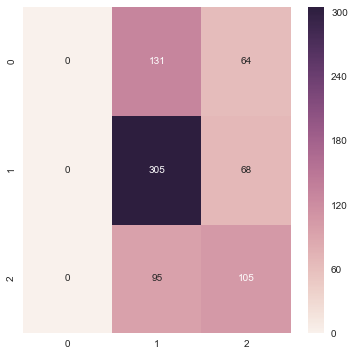

In [686]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_mat,final_predictions),annot=True, fmt="d")

### Save all soft decisions:
(in the future will include LSTM too)

In [687]:
chosen_data  = X_test
soft_decision_models = [rfc,knn,logmodel,dtree,nn_model]

all_soft_decisions = {}

for model in soft_decision_models:
    classifier_name = str(model).split("(")[0]
    if model == nn_model:
        classifier_name = "nn_model"
        
    all_soft_decisions[model] = model.predict_proba(chosen_data.as_matrix())
    #hard_decision             = model.predict(chosen_data.as_matrix())
    
    soft_decision_df = pd.DataFrame(all_soft_decisions[model],index = chosen_data.index,columns = ["MYD","MYH","MYA"])
    #hard_decision_df = pd.DataFrame(hard_decision,index = chosen_data.index)
    
    soft_decision_df.to_csv("databases/my_predictions/" + classifier_name + ".csv")

768/768 [==============================] - 5s     


#### Combine all predictions into one:

In [688]:
final_soft_decision = np.mean(list(all_soft_decisions.values()),axis=0)
final_hard_decision = final_soft_decision.argmax(axis=1)

print(classification_report(y_test,final_hard_decision.T))
print(confusion_matrix(y_test,final_hard_decision.T))

             precision    recall  f1-score   support

          0       0.26      0.19      0.22       195
          1       0.59      0.63      0.61       373
          2       0.43      0.48      0.46       200

avg / total       0.46      0.48      0.47       768

[[ 38  98  59]
 [ 72 234  67]
 [ 36  67  97]]


In [689]:
soft_decision_df = pd.DataFrame(final_soft_decision,index = chosen_data.index,columns = ["MYD","MYH","MYA"])

soft_decision_df.to_csv("databases/my_predictions/final_soft_decision.csv")

In [675]:
# num_of_clasifers  = len(models_predictions)
# len_of_prediction = len(X_test)

# all_predictions = np.concatenate(list(models_predictions.values()),axis=0)
# all_predictions = all_predictions.reshape(num_of_clasifers,len_of_prediction).T

In [676]:
# final_predictions = []
# for i in range(0,len_of_prediction):
#     predicted_class,count = np.unique(all_predictions[i],return_counts=True)
#     dic = dict(zip(predicted_class,count))
#     if 0 in list(dic) and dic[0] > 1: final_class = 0
#     else: final_class = max(dic)
#     final_predictions.append(final_class)

In [677]:
# print(classification_report(y_test,final_predictions))
# print(confusion_matrix(y_test,final_predictions))

In [678]:
# plt.figure(figsize=(6, 6))
# sns.heatmap(confusion_matrix(y_test,final_predictions),annot=True, fmt="d")

### LSTM

In [381]:
def func1(x,temp_dic,home_away,team):
    temp_dic[home_away]              = x.loc[(x[home_away + "_team_name"] == team)].copy()
    temp_dic[home_away]["home_away"] = home_away
    
def get_df(x,func,func_data):
    temp_dic = {}
    for home_away in ["home", "away"]:
        func(x,temp_dic,home_away,func_data)
    return temp_dic["home"].append(temp_dic["away"]).sort_values(["season","stage"])

In [382]:
new_matches_LSTM = final_matches_db
all_teams_LSTM = final_matches_db["home_team_name"].unique()
all_seasons_LSTM = final_matches_db['season'].unique()

In [383]:
new_matches_LSTM

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.000000,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.50,4.50,5.50,0
1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.000000,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.50,5.50,6.00,1
2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.000000,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.60,3.30,3.80,2
3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.000000,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.40,3.20,3.50,1
4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.000000,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.40,3.20,3.50,1
5,England Premier League,2008/2009,1,Everton,Blackburn Rovers,2 - 3,0.0,0.000000,0.0,0.0,...,2.00,1.95,2.05,4.00,3.50,4.00,3.30,3.10,3.30,2
6,England Premier League,2008/2009,1,Middlesbrough,Tottenham Hotspur,2 - 1,0.0,0.000000,0.0,0.0,...,3.20,2.90,3.20,2.25,2.15,2.30,3.40,3.20,3.40,1
7,England Premier League,2008/2009,1,Bolton Wanderers,Stoke City,3 - 1,0.0,0.000000,0.0,0.0,...,1.83,1.80,1.85,4.50,4.00,4.80,3.50,3.10,3.40,1
8,England Premier League,2008/2009,1,Hull City,Fulham,2 - 1,0.0,0.000000,0.0,0.0,...,2.60,2.50,2.60,2.80,2.62,2.80,3.20,2.90,3.40,1
9,England Premier League,2008/2009,1,Chelsea,Portsmouth,4 - 0,0.0,0.000000,0.0,0.0,...,1.33,1.30,1.33,10.00,8.50,11.00,5.00,4.20,5.00,1


In [384]:
first_iter = True
for team in all_teams_LSTM:
    for season in all_seasons_LSTM:
        matches_per_team        = get_df(new_matches_LSTM,func1,team)
        matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
        if len(matches_per_team_season.index) == 0: continue
        temp = matches_per_team_season.dropna(axis = 0)
        
        labels_temp = temp['win_lose_draw'].as_matrix()
        labels_temp_bin = np_utils.to_categorical(labels_temp, k)
        labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)
        
        features_temp = temp[new_new_columns] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
        matches_per_team_season_mat = features_temp.as_matrix()
        matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)
        
        if first_iter:
            Y_train = labels_temp_bin
            LSTM_matches = matches_per_team_season_mat
            first_iter = False
        else:
            LSTM_matches = np.concatenate((LSTM_matches, matches_per_team_season_mat), axis=0)
            Y_train = np.concatenate((Y_train, labels_temp_bin), axis=0)
            


In [386]:
X_train, X_test, y_train, y_test = train_test_split(LSTM_matches, Y_train, test_size=0.30, random_state=103)

In [387]:
# preprocessing
preprocessing_flag = True
if preprocessing_flag:
    x_mean = X_train.mean(axis=(0,1))
    X_train = X_train-x_mean
    x_std = X_train.std(axis=(0,1))
    X_train = X_train / x_std

In [388]:
if preprocessing_flag:
    X_test = X_test - x_mean
    X_test = X_test / x_std

In [389]:
np.shape(y_test)

(48, 24, 3)

In [390]:
np.shape(Y_train)

(160, 24, 3)

In [391]:
np.shape(LSTM_matches)

(160, 24, 26)

In [392]:
input_shape = np.shape(LSTM_matches)[1:]
L = [128,128,64]
regularization_factor = 0.01

In [393]:
input_shape = (None,input_shape[1])
input_shape

(None, 26)

In [394]:
from keras import regularizers
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model=Sequential()
model.add(TimeDistributed(Dense(L[0], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(Dropout(dropout)))
model.add(TimeDistributed(Dense(L[1], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu')))
model.add(LSTM(L[2],return_sequences=True, activation='relu'))
model.add(Dense(k, init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='softmax'))

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="normal", kernel_regularizer=<keras.reg..., activation="relu")`
  
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="normal", kernel_regularizer=<keras.reg..., activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="normal", kernel_regularizer=<keras.reg..., activation="softmax")`
  if sys.path[0] == '':


In [395]:
nb_epoch = 10
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, nb_epoch=nb_epoch,shuffle=True,validation_data=(X_test, y_test), callbacks=[early_stopping])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 112 samples, validate on 48 samples
Epoch 1/10
112/112 [==============================] - 89s - loss: 1.5763 - categorical_accuracy: 0.3865 - val_loss: 1.5323 - val_categorical_accuracy: 0.4601
Epoch 2/10
112/112 [==============================] - 89s - loss: 1.5101 - categorical_accuracy: 0.4680 - val_loss: 1.4713 - val_categorical_accuracy: 0.4601
Epoch 3/10
112/112 [==============================] - 86s - loss: 1.4478 - categorical_accuracy: 0.4680 - val_loss: 1.4127 - val_categorical_accuracy: 0.4601
Epoch 4/10
112/112 [==============================] - 83s - loss: 1.3920 - categorical_accuracy: 0.4680 - val_loss: 1.3616 - val_categorical_accuracy: 0.4601
Epoch 5/10
112/112 [==============================] - 83s - loss: 1.3487 - categorical_accuracy: 0.4680 - val_loss: 1.3240 - val_categorical_accuracy: 0.4601
Epoch 6/10
112/112 [==============================] - 84s - loss: 1.3098 - categorical_accuracy: 0.4680 - val_loss: 1.2916 - val_categorical_accuracy: 0.4601
Epoch 7

In [396]:
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, None, 128)         3456      
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 128)         0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 128)         16512     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dense_24 (Dense)             (None, None, 3)           195       
Total params: 69,571
Trainable params: 69,571
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, None, 26)
Outputs: (None, None, 3)
Actual input: (112, 24, 26)
Actual output: (112, 24, 3)


In [397]:
#a = matches_per_team_season2.as_matrix()
#np.shape(a)

In [398]:
#b=[[1,2,3],[4,5,6]]
#c= np.array(b)
#e=np.array([])
#e=np.expand_dims(e, axis=0)
#np.shape(c)

In [399]:
#np.concatenate((e,c),axis=0)

In [400]:
#d = np.expand_dims(c, axis=0)
#np.shape(d)

In [401]:
#x = np.ones((1, 2, 3))
#np.transpose(x, (1, 0, 2)).shape

In [402]:
#frames = [matches_per_team_season1, matches_per_team_season2]

#result = pd.concat(frames)
#result